# **PREDICTING STOCK PRICES ON MOSCOW EXCHANGE**

[**The Moscow Exchange**](https://www.moex.com/en/) (MOEX) is the largest exchange in Russia, operating trading markets in equities, bonds, derivatives, the foreign exchange market, money markets and precious metals.

[**MOEX Russia Index**](https://www.bloomberg.com/quote/IMOEX:IND) is cap-weighted composite index calculated based on prices of the most liquid Russian stocks of the largest and dynamically developing Russian issuers presented on the Moscow Exchange.

In this project, I am using a LSTM model to forecast stock trends based on MOEX. This is a very complex task and the combination of factors that affect stock prices are among the reasons why predicting the market is difficult.



---






I derrived daily information on [MOEX Russia Index](https://uk.finance.yahoo.com/quote/IMOEX.ME?p=IMOEX.ME) from Yahoo Finance python module that uses Yahoo's publicly available APIs  in range from 10-02-2014 till 08-04-2022 making a dataset of 1997 samples.

This 8 year span for the Russian economy particulary is interesting to analyze starting from the sanctions in 2014 for annexation of Crimea, strong healing and standing on stable legs in the run-up to the coronavirus pandemic, and now, new sanctions on the Russian economy as a result of the invasion of Ukraine.

Dataset consists of 6 columns:


1.   **Open** – Price of the stock at open market
2.   **High** – Highest price reached in the day
3.   **Low** – Lowest price reached in the day
4.   **Close** – Price of the stock at the close market
5.   **Adj Close** - Closing price after adjustments for all applicable splits and dividend distributions
6.   **Volume** - Number of shares traded


## **Data preprocessing**

In [ ]:
!pip install yfinance
!pip install yahoofinancials

Some general information about MOEX Russia Index extracted from Yahoo Finance

In [135]:
import yfinance as yahooFinance

getInfo = yahooFinance.Ticker("IMOEX.ME")
 
for key, value in getInfo.info.items():
    print(key, ":", value)

exchange : MCX
shortName : MOEX Russia Index
exchangeTimezoneName : Europe/Moscow
exchangeTimezoneShortName : MSK
isEsgPopulated : False
gmtOffSetMilliseconds : 10800000
quoteType : INDEX
symbol : IMOEX.ME
messageBoardId : finmb_INDEXIMOEX.ME
market : ru_market
previousClose : 2557.16
regularMarketOpen : 2559.22
twoHundredDayAverage : 3761.8843
trailingAnnualDividendYield : None
payoutRatio : None
volume24Hr : None
regularMarketDayHigh : 2570.78
navPrice : None
averageDailyVolume10Day : 0
totalAssets : None
regularMarketPreviousClose : 2557.16
fiftyDayAverage : 3229.5952
trailingAnnualDividendRate : None
open : 2559.22
toCurrency : None
averageVolume10days : 0
expireDate : None
yield : None
algorithm : None
dividendRate : None
exDividendDate : None
beta : None
circulatingSupply : None
startDate : None
regularMarketDayLow : 2472.28
priceHint : 2
currency : RUB
regularMarketVolume : 0
lastMarket : None
maxSupply : None
openInterest : None
marketCap : None
volumeAllCurrencies : None
strik

In [66]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials

train_set = yf.download('IMOEX.ME', 
                      start='2014-02-10', 
                      end='2022-02-20', 
                      progress=False,
)
test_set = yf.download('IMOEX.ME', 
                      start='2022-02-21', 
                      end='2022-04-09', 
                      progress=False,
)
print(test_set)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-02-21  3458.729980  3460.419922  2910.489990  3036.879883  3036.879883   
2022-02-22  2909.399902  3113.399902  2756.459961  3084.739990  3084.739990   
2022-02-24  2735.879883  2740.310059  1681.550049  2058.120117  2058.120117   
2022-02-25  2261.330078  2552.459961  2256.090088  2470.479980  2470.479980   
2022-03-28  2479.489990  2484.570068  2407.199951  2430.699951  2430.699951   
2022-03-29  2442.429932  2538.199951  2363.620117  2408.489990  2408.489990   
2022-03-30  2437.919922  2513.030029  2437.919922  2513.030029  2513.030029   
2022-03-31  2535.320068  2703.510010  2533.389893  2703.510010  2703.510010   
2022-04-01  2714.620117  2817.719971  2714.620117  2759.639893  2759.639893   
2022-04-04  2775.060059  2835.459961  2682.340088  2787.689941  2787.689941   
2022-04-05  2796.560059  2808.270020  2576.340088  2

The profit or loss calculation is usually determined either by the opening or the closing price of a stock for the day, hence we will consider the closing price as the target variable. 

**Plotting** the target variable:

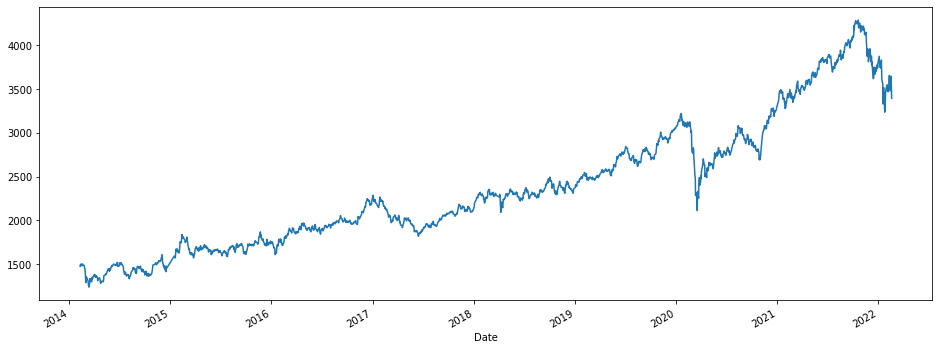

In [52]:
train_set["Close"].plot(figsize=(16,6))

Some visualizations for comparing our features.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


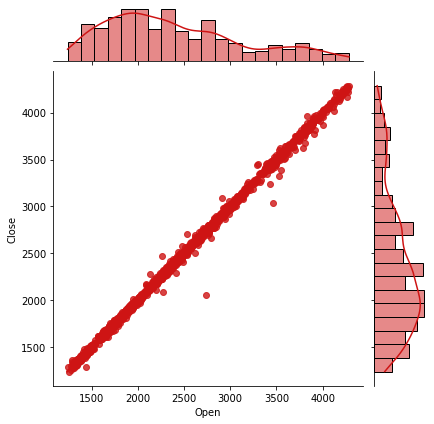

In [130]:
import seaborn as sns

dataset = pd.concat((train_set,test_set), axis = 0)
sns.jointplot(dataset.loc[:,'Open'], dataset.loc[:,'Close'], kind="reg", color="#ce1414")

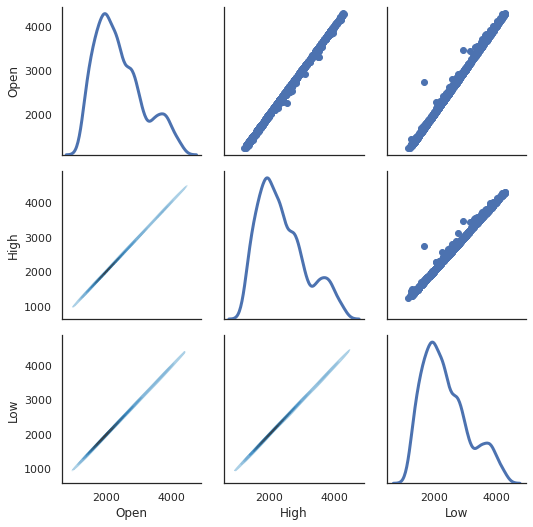

In [131]:
sns.set(style="white")
df = dataset.loc[:,['Open','High','Low']]
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

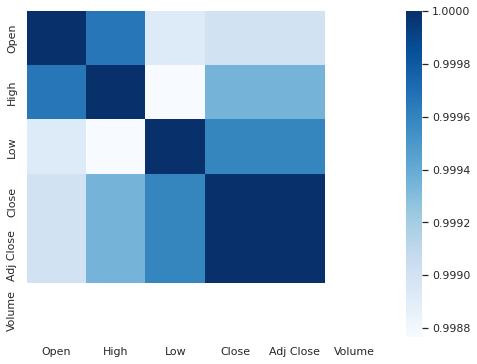

In [134]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(8,6))
sns.heatmap(dataset.corr(), cmap='Blues')
plt.show()

I can confirm that all my attributes needed are from the exact type.

In [53]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1983 entries, 2014-02-10 to 2022-02-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1983 non-null   float64
 1   High       1983 non-null   float64
 2   Low        1983 non-null   float64
 3   Close      1983 non-null   float64
 4   Adj Close  1983 non-null   float64
 5   Volume     1983 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 108.4 KB


Is there null values in the train set? No.

In [54]:
train_set.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [55]:
train_set.shape

(1983, 6)

In [56]:
train = train_set['Close']
train = pd.DataFrame(train)

## **Data transformation**

Feature scaling with MinMaxScaler to transform features by scaling each of them in range(0,1).

In [57]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0,1))
train_scaled = sc.fit_transform(train)

Creating a data structure with 60 timestamps and 1 output.

Take data from day 1 to day 60 and make prediction on the 61st day and so on.

Now the x_train data set will contain a total of 60 values, the first column will contain from the index of 0 to 59 and the second column from the index of 1 to 60, and so on.

The y_train data set will contain the 61st value at its first column located at index 60 and for the second column, it will contain the 62nd value located at index 61 and so on.

Also, as the LSTM model is expecting the data in 3-dimensional data set, using reshape() function we will reshape the data in the form of 3-dimension.

In [58]:
X_train = []
y_train = []
for i in range(60, 1983):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## **Feature extraction**

Importing keras for building deep learning models.

Because we have a time series problem, need to read the sequential data and assign it to a deep learning model.

We use dropout to reduse overfitting in the neural network.

Four LSTM layers are initialized and the output layer with units=1.

For optimizing, I use Adam optimizer which computes the learning rates based on past gradients.

In [59]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense 
# Initializing RNN
model = Sequential()

# first LSTM layer and dropout
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# second LSTM layer and dropout
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

# third LSTM layer and dropout
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

# fourth LSTM layer and dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1))

# compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')

# fitting to the training set
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
61/61 [==============================] - 15s 124ms/step - loss: 0.0149
Epoch 2/100
61/61 [==============================] - 8s 128ms/step - loss: 0.0031
Epoch 3/100
61/61 [==============================] - 8s 136ms/step - loss: 0.0033
Epoch 4/100
61/61 [==============================] - 8s 124ms/step - loss: 0.0028
Epoch 5/100
61/61 [==============================] - 8s 124ms/step - loss: 0.0032
Epoch 6/100
61/61 [==============================] - 8s 123ms/step - loss: 0.0027
Epoch 7/100
61/61 [==============================] - 8s 124ms/step - loss: 0.0026
Epoch 8/100
61/61 [==============================] - 8s 126ms/step - loss: 0.0025
Epoch 9/100
61/61 [==============================] - 8s 125ms/step - loss: 0.0023
Epoch 11/100
61/61 [==============================] - 8s 128ms/step - loss: 0.0021
Epoch 12/100
61/61 [==============================] - 8s 124ms/step - loss: 0.0022
Epoch 13/100
61/61 [==============================] - 8s 125ms/step - loss: 0.0023
Epoch 14/100

Getting the original stock price before comparing it to the predicted one.

In [60]:
stock_price = test_set.iloc[:, 4:5].values
print(stock_price)

[[3036.87988281]
 [3084.73999023]
 [2058.12011719]
 [2470.47998047]
 [2430.69995117]
 [2408.48999023]
 [2513.0300293 ]
 [2703.51000977]
 [2759.63989258]
 [2787.68994141]
 [2662.79003906]
 [2611.42993164]
 [2635.38989258]
 [2592.7199707 ]]


In [61]:
test = test_set['Close']
test = pd.DataFrame(test)

Checking the data type and non-null count.

In [62]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2022-02-21 to 2022-04-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   14 non-null     float64
dtypes: float64(1)
memory usage: 224.0 bytes


##**Visualization and prediction**

Merging the dataset and predicting the stock price.

In [63]:
dataset_new = pd.concat((train_set['Close'], test_set['Close']), axis = 0)
inputs = dataset_new[len(dataset_new) - len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [64]:
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       14 non-null     float32
dtypes: float32(1)
memory usage: 184.0 bytes


Visualizing and comparing both stock prices.

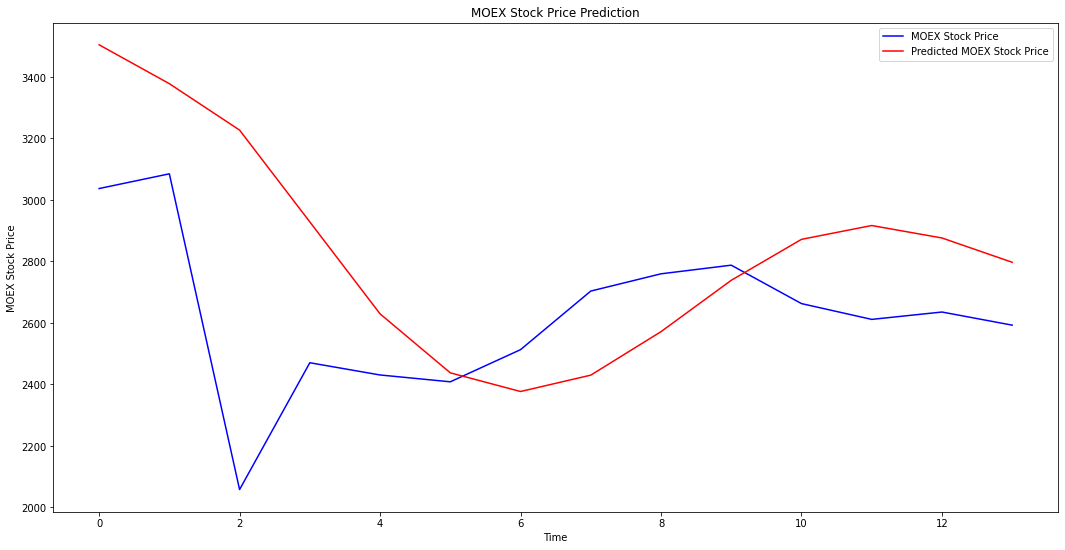

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(stock_price, color = 'blue', label = 'MOEX Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted MOEX Stock Price')
plt.title('MOEX Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MOEX Stock Price')
plt.legend()
plt.show()

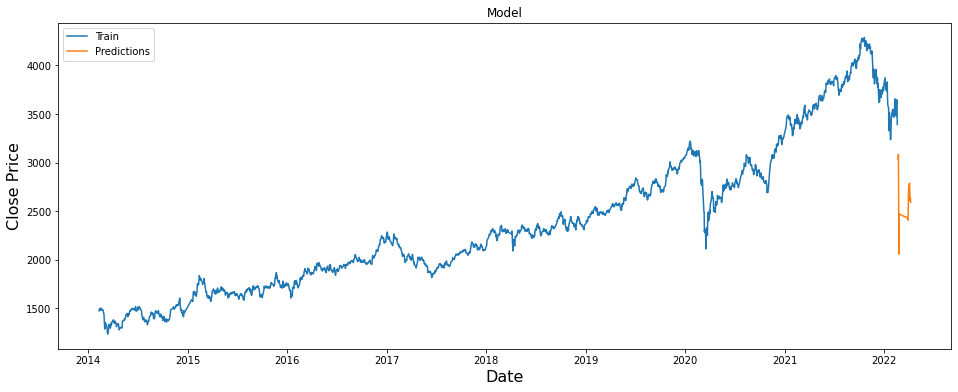

In [128]:
test['Predictions'] = predicted_stock_price

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'Predictions'], loc='upper left')
plt.show()

## **Conclusion**

In order to predict a stock ratio, a forecasting model with good accuracy is required. 

In this project, I am using one of the most precise forecasting technology with RNNs and LSTM, which are highly recommendable in the field of deep learning.

**The goal** of this study is to provide the investors, brokers or anyone interested in stock market a good understanding and insight of the future situation on the market. Maybe, these predictive methods won't get the price 100% correctly, but they are highly accurate when predicting the trend as we can see from our visualizations.

**Moscow Exchange** is going through a uncertain times and it was challenging for me to use this exact data to perform some predictive modeling. There are way to many factors influencing the trade market in the Russian Federation and to involve all of them need some serious dedication and financial expertise. 